In [2]:
import struct
import numpy as np
import intvalpy as ip
from functools import cmp_to_key
import matplotlib.pyplot as plt

In [3]:
def read_bin_file_with_numpy(file_path):
    with open(file_path, 'rb') as f:
        header_data = f.read(256)
        side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

        frames = []
        point_dtype = np.dtype('<8H')

        for _ in range(frame_count):
            frame_header_data = f.read(16)
            stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
            frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
            frames.append(frame_data)

        return np.array(frames)

In [4]:
def convert_to_voltage(data):
    return data / 16384.0 - 0.5


def are_intersected(x, y):
    sup = y.a if x.a < y.a else x.a
    inf = x.b if x.b < y.b else y.b
    return sup - inf <= 1e-15


def are_adjusted_to_each_other(x, y):
    return x.b == y.a or y.b == x.a


def merge_intervals(x, y):
    return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [5]:
def mode(x):
    if len(x) == 0:
        return []

    edges = set()
    for x_i in x:
        edges.add(x_i.a)
        edges.add(x_i.b)
    edges = sorted(list(edges))

    z = []
    for index, a in enumerate(edges):
        b = a if index == len(edges) - 1 else edges[index + 1]
        z.append(ip.Interval(a, b))

    mu = []
    for z_i in z:
        mu_i = 0
        for x_i in x:
            if z_i in x_i:
                mu_i += 1
        mu.append(mu_i)

    max_mu = max(mu)
    K = [index for index, element in enumerate(mu) if element == max_mu]

    m = [z[k] for k in K]
    merged_m = []

    current_interval = m[0]

    for next_interval in m[1:]:
        if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval,
                                                                                          next_interval):
            current_interval = merge_intervals(current_interval, next_interval)
        else:
            merged_m.append(current_interval)
            current_interval = next_interval

    merged_m.append(current_interval)

    if len(merged_m) == 1:
        return merged_m[0]
        
    return ip.Interval(min([inter.a for inter in merged_m]), max([inter.b for inter in merged_m]))

In [6]:
def med_k(x):
    starts = [float(interval.a) for interval in x]
    ends = [float(interval.b) for interval in x]
    return ip.Interval(np.median(starts), np.median(ends))


def med_p(x):
    x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))
    mid = len(x) // 2

    if len(x) % 2 == 0:
        return (x[mid - 1] + x[mid]) / 2

    return x[mid]

In [7]:
def jaccard_sequence_index(x, y):
    results = []

    for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

    return np.array(results)


def jaccard_index(x, y):
    return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))

In [8]:
def scalar_to_interval(x, rad):
    return ip.Interval(x - rad, x + rad)


def med(x):
    return float((x.a + x.b) / 2)

In [9]:
scalar_to_interval_vec = np.vectorize(scalar_to_interval)
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

In [10]:
x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

In [11]:
print(x_voltage.shape)
x_voltage = np.transpose(x_voltage, axes=(2,1,0))
y_voltage = np.transpose(y_voltage, axes=(2,1,0))
print(x_voltage.shape)
# x_voltage = x_voltage.flatten()
# y_voltage = y_voltage.flatten()

(100, 1024, 8)
(8, 1024, 100)


(array([ 3., 10.,  9., 12., 18., 13., 11., 11.,  4.,  9.]),
 array([-0.19683838, -0.19412231, -0.19140625, -0.18869019, -0.18597412,
        -0.18325806, -0.18054199, -0.17782593, -0.17510986, -0.1723938 ,
        -0.16967773]),
 <BarContainer object of 10 artists>)

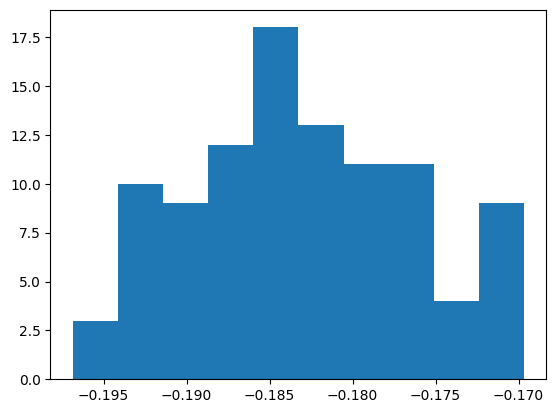

In [12]:
plt.hist(x_voltage[0,0,:], )

(array([ 5., 18., 10., 18.,  9., 11.,  9.,  5.,  8.,  7.]),
 array([0.16223145, 0.16482544, 0.16741943, 0.17001343, 0.17260742,
        0.17520142, 0.17779541, 0.1803894 , 0.1829834 , 0.18557739,
        0.18817139]),
 <BarContainer object of 10 artists>)

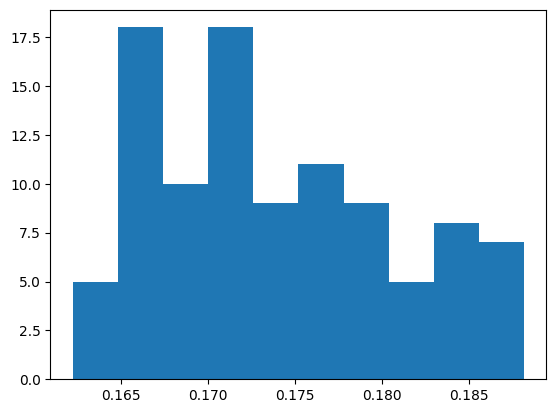

In [13]:
plt.hist(y_voltage[0,0,:], )

In [14]:
x_voltage = np.mean(x_voltage, axis = 2)
y_voltage = np.mean(y_voltage, axis = 2)

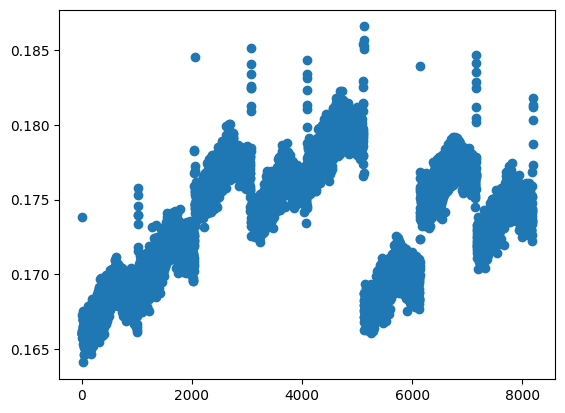

In [15]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())

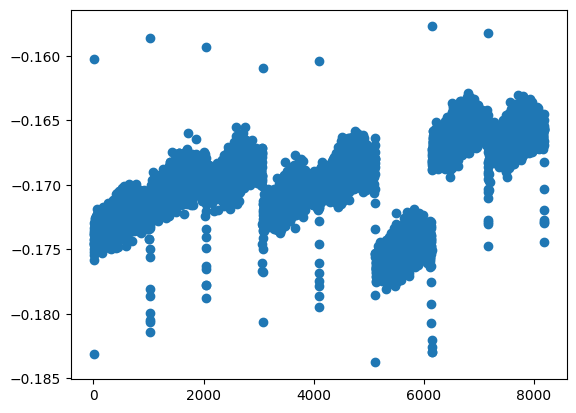

In [16]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())

In [17]:
x_voltage = x_voltage[0].flatten()
y_voltage = y_voltage[0].flatten()

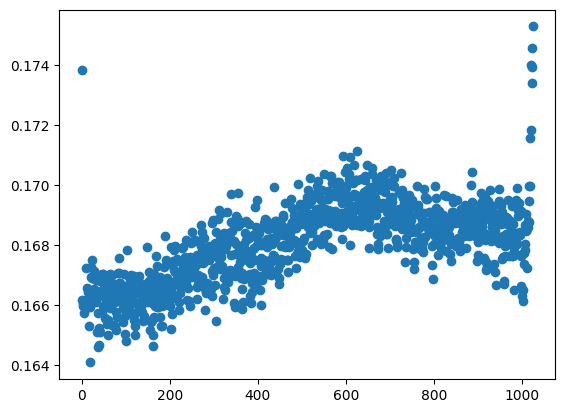

In [18]:
plt.scatter(list(range(1, y_voltage.shape[0]  + 1)), y_voltage)

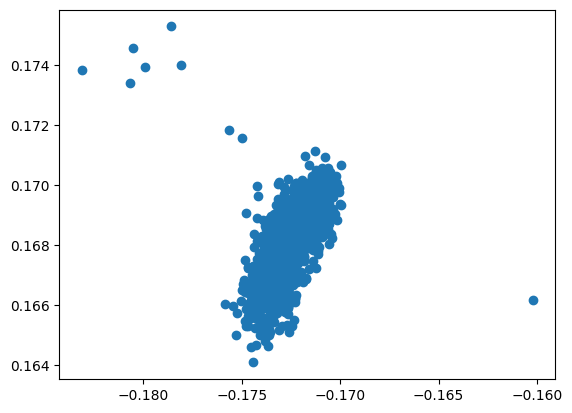

In [19]:
plt.scatter(x_voltage, y_voltage)

(array([  1.,   4.,   1., 106., 668., 243.,   0.,   0.,   0.,   1.]),
 array([-0.18310974, -0.18081976, -0.17852979, -0.17623981, -0.17394983,
        -0.17165985, -0.16936987, -0.1670799 , -0.16478992, -0.16249994,
        -0.16020996]),
 <BarContainer object of 10 artists>)

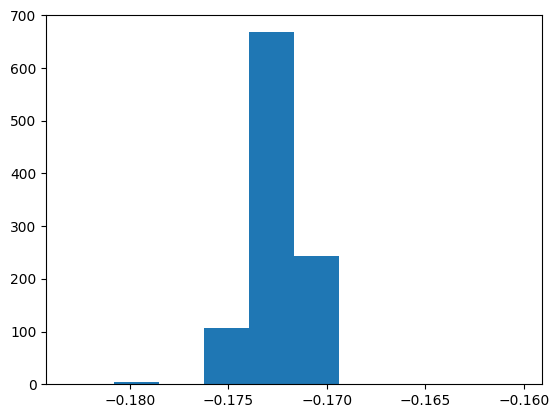

In [20]:
plt.hist(x_voltage)

(array([ 13., 108., 206., 286., 322.,  78.,   5.,   0.,   4.,   2.]),
 array([0.1640918 , 0.16521155, 0.1663313 , 0.16745105, 0.1685708 ,
        0.16969055, 0.1708103 , 0.17193005, 0.1730498 , 0.17416956,
        0.17528931]),
 <BarContainer object of 10 artists>)

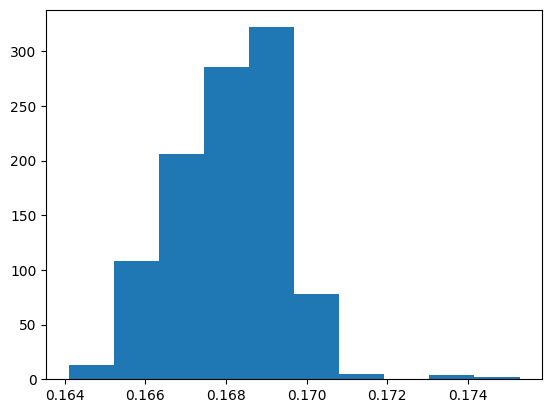

In [21]:
plt.hist(y_voltage)

In [22]:
z_scores_x = np.abs((x_voltage - np.mean(x_voltage)) / np.std(x_voltage))
z_scores_y = np.abs((y_voltage - np.mean(y_voltage)) / np.std(y_voltage))

threshold = 3

filtered_indices = (z_scores_x < threshold) & (z_scores_y < threshold)
x_voltage = x_voltage[filtered_indices]
y_voltage = y_voltage[filtered_indices]

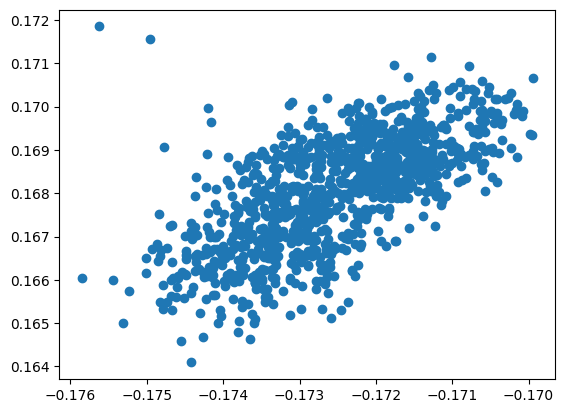

In [23]:
plt.scatter(x_voltage, y_voltage)

In [24]:
N = -14
rad = 2 ** N

x_voltage_int = scalar_to_interval_vec(x_voltage, rad)
y_voltage_int = scalar_to_interval_vec(y_voltage, rad)

In [25]:
# x_voltage_int_flatten = x_voltage_int.flatten()
# y_voltage_int_flatten = y_voltage_int.flatten()
# x_voltage_int_flatten = x_voltage_int[0].flatten()
# y_voltage_int_flatten = y_voltage_int[0].flatten()
x_voltage_int_flatten = x_voltage_int.flatten()
y_voltage_int_flatten = y_voltage_int.flatten()

# a + X = Y

In [26]:
a_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) - max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) - min(x_voltage_int_flatten, key=lambda x: med(x))]
print(a_bounds)
a_bounds.sort()
a_bounds = [med(interval) for interval in a_bounds]
print(a_bounds)

['[0.333913, 0.334157]', '[0.347576, 0.34782]']
[0.3340350341796875, 0.34769775390625]


In [27]:
iters = 150

In [28]:
a = np.linspace(a_bounds[0], a_bounds[1], iters)
print(f"step: {np.abs(a_bounds[1] - a_bounds[0]) / iters}")

step: 9.108479817708348e-05


In [29]:
print(x_voltage_int_flatten.shape)
print(y_voltage_int_flatten.shape)
unprocessed_data = []
def estimate(a_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
vec_estimate = np.vectorize(estimate)

data = vec_estimate(a)

(1017,)
(1017,)


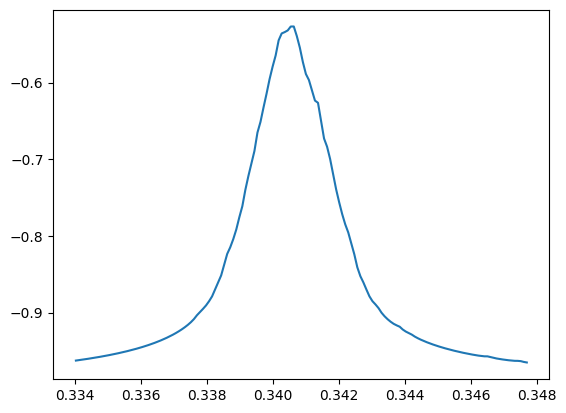

In [30]:
plt.plot(a, data)

In [31]:
print(np.argmax(data))
print(a[np.argmax(data)])

72
0.34063715377910025


In [32]:
def estimate_mod(a_val):
    mode_x = mode(x_voltage_int_flatten + a_val)
    mode_y = mode(y_voltage_int_flatten)
    return jaccard_index(mode(x_voltage_int_flatten + a_val), mode(y_voltage_int_flatten))
def estimate_med_p(a_val):
    return jaccard_index(med_p(x_voltage_int_flatten + a_val), med_p(y_voltage_int_flatten))
def estimate_med_k(a_val):
    return jaccard_index(med_k(x_voltage_int_flatten + a_val), med_k(y_voltage_int_flatten))

In [33]:
vec_estimate_mod = np.vectorize(estimate_mod)
vec_estimate_med_p = np.vectorize(estimate_med_p)
vec_estimate_med_k = np.vectorize(estimate_med_k)

In [34]:
data_med_p = vec_estimate_med_p(a)
data_med_k = vec_estimate_med_k(a)

### Интерполированные данные

In [35]:
from scipy.interpolate import interp1d
data = np.array([float(item) for item in data])
data_med_k = np.array([float(item) for item in data_med_k])
data_med_p = np.array([float(item) for item in data_med_p])

In [36]:
def process_data(point_data, a_data, flag = True):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"a: {a_data[max_idx]}")
    f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
    f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
    
    plt.plot(a_data, point_data)
    if flag:
        internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
        print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
        external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
        print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
        plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = 'internal', colors = 'green')
        plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = 'external', colors = 'red')
        plt.legend()

max y: -0.5267716303774015
min y: -0.9649823995483016
a: 0.34063715377910025
internal: -0.6363243226701265, x=[0.3397008904238657,0.34141029023560326]
external: -0.8554297072555765, x=[0.3383961293286589,0.34268830645431664]


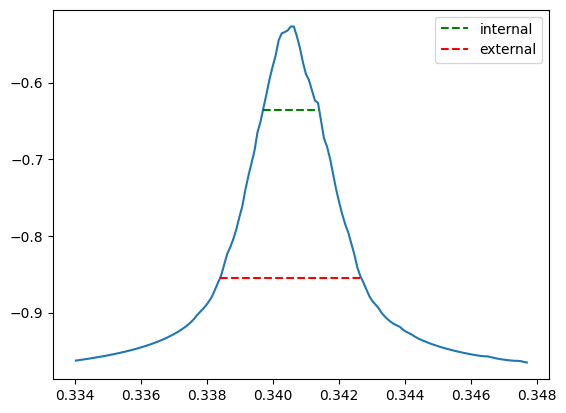

In [37]:
process_data(data, a)

max y: 0.6676926520788942
min y: -0.965451718776991
a: 0.34072884988464763
internal: 0.25940655936492285, x=[0.3406705603771064,0.340826943425235]
external: -0.5571656260630197, x=[0.34032022563122327,0.34118319054566604]


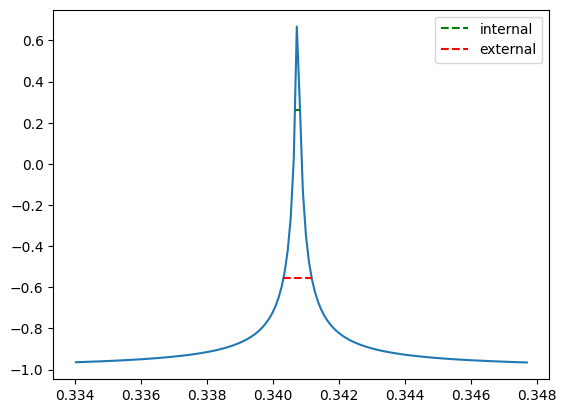

In [38]:
process_data(data_med_k, a)

max y: 0.667692652078817
min y: -0.965451718776991
a: 0.34072884988464763
internal: 0.259406559364865, x=[0.3406705603771064,0.340826943425235]
external: -0.557165626063039, x=[0.34032022563122327,0.3411831905456661]


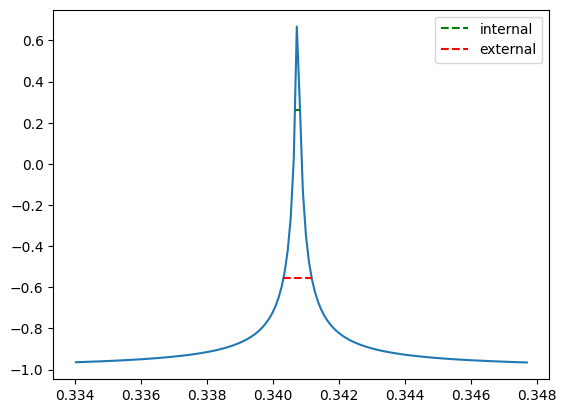

In [39]:
process_data(data_med_p, a)

In [40]:
data_mod = vec_estimate_mod(a)
data_mod = np.array([float(item) for item in data_mod])

KeyboardInterrupt: 

In [ ]:
process_data(data_mod, a, False)

# t * X = Y

In [ ]:
def estimate_t(t_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
vec_estimate_t = np.vectorize(estimate_t)

In [ ]:
def estimate_mod_t(t_val):
    return jaccard_index(mode(x_voltage_int_flatten * t_val), mode(y_voltage_int_flatten))
def estimate_med_p_t(t_val):
    return jaccard_index(med_p(x_voltage_int_flatten * t_val), med_p(y_voltage_int_flatten))
def estimate_med_k_t(t_val):
    return jaccard_index(med_k(x_voltage_int_flatten * t_val), med_k(y_voltage_int_flatten))

In [ ]:
vec_estimate_mod_t = np.vectorize(estimate_mod_t)
vec_estimate_med_p_t = np.vectorize(estimate_med_k_t)
vec_estimate_med_k_t = np.vectorize(estimate_med_p_t)

In [ ]:
def process_data_t(point_data, a_data, show = True):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"t: {a_data[max_idx]}")
    plt.plot(a_data, point_data)
    if show:
        f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
        f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
        
        internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
        print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
        external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
        print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
        plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = 'internal', colors = 'green')
        plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = 'external', colors = 'red')
        plt.legend()

### Расширенные границы и количество итераций

In [ ]:
# t_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) / max(x_voltage_int_flatten, key=lambda x: med(x)),
#            max(y_voltage_int_flatten, key=lambda x: med(x)) / min(x_voltage_int_flatten, key=lambda x: med(x))]
# t_bounds.sort()
# t_bounds = [med(interval) for interval in t_bounds]
# t_bounds[0] -= 0.05
# t_bounds[1] += 0.05
# print(t_bounds)

In [ ]:
# iters = 300
# t = np.linspace(t_bounds[0], t_bounds[1], iters)
# print(f"step: {np.abs(t_bounds[1] - t_bounds[0]) / iters}")

In [ ]:
# data_med_p_t = vec_estimate_med_p_t(t)
# data_med_k_t = vec_estimate_med_k_t(t)

In [ ]:
# data_t = vec_estimate(t)

In [ ]:
# data_t = np.array([float(item) for item in data_t])
# data_med_k_t = np.array([float(item) for item in data_med_k_t])
# data_med_p_t = np.array([float(item) for item in data_med_p_t])

In [ ]:
# plt.plot(t, data_t) 

In [ ]:
# print(np.argmax(data_t))
# print(data_t[np.argmax(data_t)])
# print(t[np.argmax(data_t)])

In [ ]:
# process_data_t(data_med_k_t, t)

In [ ]:
# process_data_t(data_med_p_t, t)

### Стандартные размеры границ

In [ ]:
t_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) / max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) / min(x_voltage_int_flatten, key=lambda x: med(x))]
t_bounds.sort()
t_bounds = [med(interval) for interval in t_bounds]
print(t_bounds)

In [ ]:
iters = 70
t = np.linspace(t_bounds[0], t_bounds[1], iters)
print(f"step: {np.abs(t_bounds[1] - t_bounds[0]) / iters}")

In [ ]:
data_med_p_t = vec_estimate_med_p_t(t)
data_med_k_t = vec_estimate_med_k_t(t)

In [ ]:
data_t = vec_estimate_t(t)

In [ ]:
data_t = np.array([float(item) for item in data_t])
data_med_k_t = np.array([float(item) for item in data_med_k_t])
data_med_p_t = np.array([float(item) for item in data_med_p_t])

In [ ]:
process_data_t(data_t, t, False)

In [ ]:
print(np.argmax(data_t))
print(data_t[np.argmax(data_t)])
print(t[np.argmax(data_t)])

In [ ]:
process_data_t(data_med_k_t, t, False)

In [ ]:
process_data_t(data_med_p_t, t, False)

In [ ]:
data_mod_t = vec_estimate_mod_t(t)
data_mod_t = np.array([float(item) for item in data_mod_t])

In [ ]:
process_data_t(data_mod_t, t, False)